In [1]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from itertools import product
from perlin_numpy import generate_perlin_noise_2d
from scipy.interpolate import griddata
from scipy.stats import percentileofscore
from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from GPyOpt.methods import BayesianOptimization

In [2]:
# Random seed
np.random.seed(1)

m = 5 # Physical observations per iteration (Default 5)
n = 100 # Simulated observations per iteration (Default 100)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 1

# Minimum percentile to explore each iteration
percentile = 50

# Number of iterations to run the active learning loop (Default 10)
iterations = 10

# Corrective constant when calculating percentages
laplace_alpha = 0.01

# Degree of the polynomial to fit to the data
degree = 2

In [3]:
# List of benchmark functions to test
ackley = lambda X, Y: -(20 * (1 - np.exp(-0.2 * np.sqrt(0.5 * (X**2 + Y**2)))) - np.exp(0.5 * (np.cos(2 * np.pi * X) + np.cos(2 * np. pi * Y))) + np.exp(1))
beale = lambda X, Y: -((1.5 - X + X * Y)**2 + (2.25 - X + X * Y**2)**2 + (2.625 - X + X * Y**3)**2)
bird = lambda X, Y: -(np.sin(X) * np.exp((1 - np.cos(Y))**2) + np.cos(Y) * np.exp((1 - np.sin(X))**2) + (X - Y)**2)
booth = lambda X, Y: -((X + 2 * Y - 7)**2 + (2 * X + Y - 5)**2)
bukin6 = lambda X, Y: -(100 * np.sqrt(abs(Y - 0.01 * X**2)) + 0.01 * np.abs(X + 10))
crossintray = lambda X, Y: 0.0001 * (np.abs(np.sin(X) * np.sin(Y) * np.exp(np.abs(100 - np.sqrt(X**2 + Y**2) / np.pi))) + 1)**0.1
crownedcross = lambda X, Y: -0.0001 * (np.abs(np.sin(X) * np.sin(Y) * np.exp(np.abs(100 - np.sqrt(X**2 + Y**2) / np.pi))) + 1)**0.1
goldsteinprice = lambda X, Y: -(1 + (X + Y + 1)**2 * (19 - 14 * X + 3 * X**2 - 14 * Y + 6 * X * Y + 3 * Y**2)) * (30 + (2 * X - 3 * Y)**2 * (18 - 32 * X + 12 * X**2 + 48 * Y - 36 * X * Y + 27 * Y**2))
griewank = lambda X, Y: -((X**2 + Y**2) / 200 - np.cos(X) * np.cos(Y / np.sqrt(2)) + 1)
himmelblau = lambda X, Y: -((X**2 + Y - 11)**2 + (X + Y**2 - 7)**2)
holdertable = lambda X, Y: np.abs(np.sin(X) * np.cos(Y) * np.exp(np.abs(1 - np.sqrt(X**2 + Y**2) / np.pi)))
leon = lambda X, Y: -(100 * (Y - X**3)**2 + (1 - X)**2)
levi13 = lambda X, Y: -(np.sin(3 * np.pi * X)**2 + (X - 1)**2 * (1 + np.sin(3 * np.pi * Y)**2) + (Y - 1)**2 * (1 + np.sin(2 * np.pi * Y)**2))
matyas = lambda X, Y: -(0.26 * (X**2 + Y**2) - 0.48 * X * Y)
mccormick = lambda X, Y: -(np.sin(X + Y) + (X - Y)**2 - 1.5 * X + 2.5 * Y + 1)
penholder = lambda X, Y: np.exp(-(np.abs(np.cos(X) * np.cos(Y) * np.exp(np.abs(1 - np.sqrt(X**2 + Y**2) / np.pi))))**-1)
perlin = lambda X, Y: generate_perlin_noise_2d((X.shape[0], X.shape[1]), (2, 2))
rastrigin = lambda X, Y: -(X**2 + Y**2 - 10 * np.cos(2 * np.pi * X) - 10 * np.cos(2 * np.pi * Y) + 2)
schweffel = lambda X, Y: X * np.sin(np.sqrt(np.abs(X))) + Y * np.sin(np.sqrt(np.abs(Y)))
sixhumpcamel = lambda X, Y: -((4 - 2.1 * X**2 + X**4 / 3) * X**2 + X * Y + (4 * Y**2 - 4) * Y**2)
testtubeholder = lambda X, Y: 4 * np.abs(np.sin(X) * np.cos(Y) * np.exp(np.abs(np.cos((X**2 + Y**2) / 200))))
zettl = lambda X, Y: -((X**2 + Y**2 - 2 * X)**2 + X / 4)
# ===KS===
xsinx = lambda X: X*np.sin(X)

# Dictionary of benchmark functions with their bounds
objectives = {
    "ackley": {
        "func": ackley,
        "bounds": [(-35, 35)] * 2
    },
    "beale": {
        "func": beale,
        "bounds": [(-4.5, 4.5)] * 2
    },
    "bird": {
        "func": bird,
        "bounds": [(-2 * np.pi, 2 * np.pi)] * 2
    },
    "booth": {
        "func": booth,
        "bounds": [(-10, 10)] * 2
    },
    "bukin6": {
        "func": bukin6,
        "bounds": [(-15, 5), (-3, 3)]
    },
    "crossintray": {
        "func": crossintray,
        "bounds": [(-10, 10)] * 2
    },
    "crownedcross": {
        "func": crownedcross,
        "bounds": [(-10, 10)] * 2
    },
    "goldsteinprice": {
        "func": goldsteinprice,
        "bounds": [(-2, 2)] * 2
    },
    "griewank": {
        "func": griewank,
        "bounds": [(-100, 100)] * 2
    },
    "himmelblau": {
        "func": himmelblau,
        "bounds": [(-5, 5)] * 2
    },
    "holdertable": {
        "func": holdertable,
        "bounds": [(-10, 10)] * 2
    },
    "leon": {
        "func": leon,
        "bounds": [(-1.2, 1.2)] * 2
    },
    "levi13": {
        "func": levi13,
        "bounds": [(-10, 10)] * 2
    },
    "matyas": {
        "func": matyas,
        "bounds": [(-10, 10)] * 2
    },
    "mccormick": {
        "func": mccormick,
        "bounds": [(-1.5, 4), (-3, 4)]
    },
    "penholder": {
        "func": penholder,
        "bounds": [(-11, 11)] * 2
    },
    "perlin": {
        "func": perlin,
        "bounds": [(-1, 1)] * 2
    },
    "rastrigin": {
        "func": rastrigin,
        "bounds": [(-5.12, 5.12)] * 2
    },
    "schweffel": {
        "func": schweffel,
        "bounds": [(-500, 500)] * 2
    },
    "sixhumpcamel": {
        "func": sixhumpcamel,
        "bounds": [(-5, 5)] * 2
    },
    "testtubeholder": {
        "func": testtubeholder,
        "bounds": [(-10, 10)] * 2
    },
    "zettl": {
        "func": zettl,
        "bounds": [(-5, 5)] * 2
    },
    "xsinx": {
        "func": xsinx,
        "bounds": [(-5, 20)]
    }
}

In [4]:
# Random seed
np.random.seed(1)

m = 5 # Physical observations per iteration (Default 5)
n = 100 # Simulated observations per iteration (Default 100)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 10

# Minimum percentile to explore each iteration
percentile = 50

# Number of iterations to run the active learning loop (Default 10)
iterations = 10

# Corrective constant when calculating percentages
laplace_alpha = 0.01

# Degree of the polynomial to fit to the data
degree = 2

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [5]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, a, b: 0.1*(a - 4) * x + 0.05*(b + 3) * x**2 + r.normal(0,sim_stdev)

1D Functions

In [6]:
# Silence repetitive warnings
warnings.simplefilter('ignore')

# Run the active learning loop for each 2D benchmark function
obj = "xsinx"
# Get the bounds for the function
x_range = objectives[obj]["bounds"]

sim_eval = lambda x, a, b: objectives[obj]["func"](x) + sim_err(x, a, b)

# Generate the meshgrid and response for the plots
X = np.arange(*x_range[0], ((x_range[0][1] - x_range[0][0]) / 100))
Z = objectives[obj]["func"](X)

# Generate the initial physical experiments
#df = pd.DataFrame(np.random.uniform(x_range[0][0], x_range[0][1], size=(pretrain_n, 1)))
df = pd.DataFrame(r.uniform(x_range[0][0], x_range[0][1], size=(pretrain_n, 1)))
#print(df)

# Rename the column with sampled points
df.columns = ["x"]

# Calculate the z column with some random error
df["z"] = objectives[obj]["func"](df["x"]) + ran_err(pretrain_n, 0.05)

print(df)


           x          z
0   1.540303   1.588466
1   2.462279   1.531422
2  15.355644   5.282423
3  -2.702101   1.110080
4  10.002513  -5.439906
5  13.214013   7.967160
6  -0.302473   0.117366
7  -3.621334  -1.701786
8   1.874234   1.794951
9  11.435825 -10.389972


In [9]:
# # Adjusting physical data points 
# # Dynamic adjustment parameters
# uncertainty_threshold = 0.1
# error_threshold = 0.1
# dynamic_adjustment_factor = 1.5
# def adjust_sampling_strategy(df, model, m):
#     mean, std = model.predict(df[["x"]], return_std=True)
#     uncertainty = std.mean()
#     error = np.abs(df["z"] - df["sim_z"]).mean()

#     if uncertainty > uncertainty_threshold or error > error_threshold:
#         new_m = int(m * dynamic_adjustment_factor)
#     else:
#         new_m = m

#     return new_m

# This function can be repeated in a loop
def perform_iteration(df):
  # Function to simulate all points x in df
  # x is numpy array with elements x[0,0] and x[0,1] representing a and b
  # Returns sum of squared error between simulated and physical
  def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

  bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (2,5)},
          {'name': 'b', 'type': 'continuous', 'domain': (-4,-1)}]

  # Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
  bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
  bo.run_optimization(max_iter=max_bo_iter)
  df["a"] = bo.x_opt[0]
  df["b"] = bo.x_opt[1]
  print(bo.x_opt)
  # print(df)

  # Train a GP using calibrated simulation model
  # krnl = (df["sim_z"].std())**2 * RBF(length_scale=1) + WhiteKernel(noise_level=(df["diff"].std())**2)
  # model = GaussianProcessRegressor(kernel=krnl, normalize_y=False, random_state=3, alpha=1e-10)
  krnl = C(1, (1e-3, 1e3)) * RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
  model = GaussianProcessRegressor(kernel=krnl, normalize_y=True, random_state=3)
  model.fit(df[["x"]], df["sim_z"])


  # Metropolis Hastings to sample points proportional to p, where p = gp_upper - median simulated val
  # Define probability function p(x) = gp_upper - median simulated val
  def p(x):
    v, s = model.predict(x.reshape(-1,1), return_std=True)
    if x[0,0] >= x_range[0][0] and x[0,0] <= x_range[0][1]:
      return np.max([v[0] + 1.96*s[0] - df["sim_z"].median(), 0])
    else:
      return 0

  # Metropolis step proposal distribution N(0,sig**2) 
  # Generates candidate point and decides to accept or reject it based on acceptance ratio
  def metropolis_step(x, sig):
    prop_x = x + r.normal(0, sig, size=x.shape)
    u = r.uniform(0,1)
    if u < np.min([1.0, p(prop_x) / p(x)]):
      value = prop_x
    else:
      value = x
    return value

  # Metropolis hastings sampler
  # sig = stdev of proposal dist
  # sample_size = num samples
  # burn_in = num samples to throw out before recording
  # start at x with largest simulated response
  def mh_sampler(sig, sample_size, burn_in, lag):
    x = np.array([[df["x"].loc[np.argmax(df["sim_z"])]]]) 
    for i in range(burn_in):
      x = metropolis_step(x, sig)
    output = x
    for i in range(sample_size-1):
      for j in range(lag):
        x = metropolis_step(x, sig)
      output = np.vstack((output,x))
    return output # Generates the specified number of samples (sample_size) with a lag between samples to reduce autocorrelation.

  # Use MH to sample settings for new physical experiments
  X_mh = mh_sampler(5, m, 300, 30)
  temp_df = pd.DataFrame(X_mh)
  temp_df.columns = ["x"]
  #print(temp_df)
  temp_df["z"] = objectives[obj]["func"](temp_df["x"]) + ran_err(m, 0.05)
  temp_df["a"] = bo.x_opt[0]
  temp_df["b"] = bo.x_opt[1]
  temp_df["sim_z"] = sim_eval(temp_df["x"], temp_df["a"], temp_df["b"])
  temp_df["diff"] = temp_df["z"] - temp_df["sim_z"]


  # Plot GP predictions and experiments w/ physical/simulated response
  mean, std = model.predict(X.reshape(-1,1), return_std=True)
  plt.plot(X, Z, label=r"Actual function, $f(x)$")
  plt.plot(X, mean, label=r"GP of simulated responses, $g(x)$")
  plt.fill_between(
      X.ravel(),
      mean - 1.96 * std,
      mean + 1.96 * std,
      alpha=0.5,
      label=r"95% confidence interval",
  )
  plt.scatter(df["x"], df["z"], label=r"Physical experiments (cumulative)")
  plt.scatter(df["x"], df["sim_z"], label=r"Simulated experiments (cumulative)")
  plt.scatter(temp_df["x"], temp_df["z"], label=r"Physical experiments (next iteration)")

  plt.legend()
  _ = plt.title(obj)

  # Add new experiments to dataframe that holds all physical experiments
  df = pd.concat([df, temp_df], ignore_index=True)
  return(df)

[ 4.04625331 -3.0107103 ]
            x          z         a        b      sim_z       diff
0    1.540303   1.588466  4.046253 -3.01071   1.482843   0.105623
1    2.462279   1.531422  4.046253 -3.01071   1.672352  -0.140930
2   15.355644   5.282423  4.046253 -3.01071  25.571255 -20.288832
3   -2.702101   1.110080  4.046253 -3.01071   2.419566  -1.309486
4   10.002513  -5.439906  4.046253 -3.01071   2.456861  -7.896766
5   13.214013   7.967160  4.046253 -3.01071  22.622922 -14.655762
6   -0.302473   0.117366  4.046253 -3.01071   0.172689  -0.055324
7   -3.621334  -1.701786  4.046253 -3.01071   0.354706  -2.056492
8    1.874234   1.794951  4.046253 -3.01071   1.778435   0.016516
9   11.435825 -10.389972  4.046253 -3.01071   0.326547 -10.716519
10  18.086208 -12.612300  4.046253 -3.01071 -12.581887  -0.030413
11  17.275437 -17.301236  4.046253 -3.01071 -17.341832   0.040596
12   8.885376   4.541148  4.046253 -3.01071   4.575979  -0.034831
13  14.271779  14.181231  4.046253 -3.01071  14.11

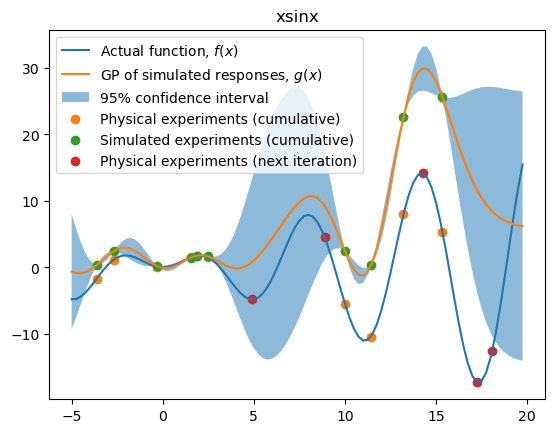

In [10]:
df = perform_iteration(df)
print(df)

[ 4.09936897 -3.01924707]


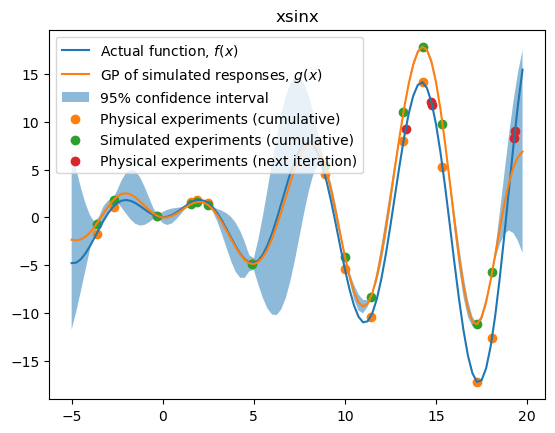

In [11]:
df = perform_iteration(df)

[ 3.94000479 -2.99031289]
            x          z         a         b      sim_z       diff
0    1.540303   1.588466  3.940005 -2.990313   1.519986   0.068479
1    2.462279   1.531422  3.940005 -2.990313   1.726254  -0.194832
2   15.355644   5.282423  3.940005 -2.990313  25.557311 -20.274889
3   -2.702101   1.110080  3.940005 -2.990313   2.342423  -1.232343
4   10.002513  -5.439906  3.940005 -2.990313   2.539568  -7.979473
5   13.214013   7.967160  3.940005 -2.990313  22.659314 -14.692154
6   -0.302473   0.117366  3.940005 -2.990313   0.167693  -0.050327
7   -3.621334  -1.701786  3.940005 -2.990313   0.244749  -1.946536
8    1.874234   1.794951  3.940005 -2.990313   1.821982  -0.027031
9   11.435825 -10.389972  3.940005 -2.990313   0.392907 -10.782880
10  18.086208 -12.612300  3.940005 -2.990313  16.149880 -28.762180
11  17.275437 -17.301236  3.940005 -2.990313   8.734433 -26.035669
12   8.885376   4.541148  3.940005 -2.990313  10.710139  -6.168991
13  14.271779  14.181231  3.940005 -

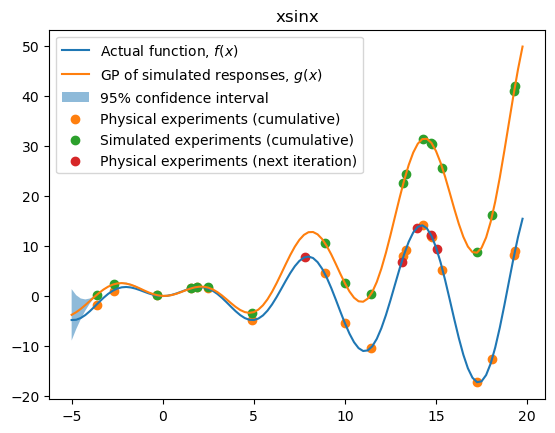

In [12]:
df = perform_iteration(df)
print(df)